In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st

In [62]:
import os
plt.style.use(os.path.join(os.getcwd(), 'mystyle.mplstyle') )

# Get the data

In [63]:
import urllib.request
suicide_rate_url = 'http://apps.who.int/gho/athena/data/xmart.csv?target=GHO/MH_12&profile=crosstable&filter=COUNTRY:*;REGION:*&x-sideaxis=COUNTRY&x-topaxis=GHO;YEAR;SEX'
local_filename, headers = urllib.request.urlretrieve(suicide_rate_url, filename='who_suicide_rates.csv')
#local_filename, headers = urllib.request.urlretrieve(sucide_rate_url)

In [64]:
local_filename = 'data/who_suicide_rates.csv_backup'
import pandas.io.data
rates = pandas.read_csv(local_filename, names=['Country','Both', 'Female', 'Male'], skiprows=3)
rates.head(10)

Country  Both  Female  Male
0  Afghanistan   5.7     5.3   6.2
1      Albania   5.9     5.2   6.6
2      Algeria   1.9     1.5   2.3
3       Angola  13.8     7.3  20.7
4    Argentina  10.3     4.1  17.2
5      Armenia   2.9     0.9   5.0
6    Australia  10.6     5.2  16.1
7      Austria  11.5     5.4  18.2
8   Azerbaijan   1.7     1.0   2.4
9      Bahamas   2.3     1.3   3.6

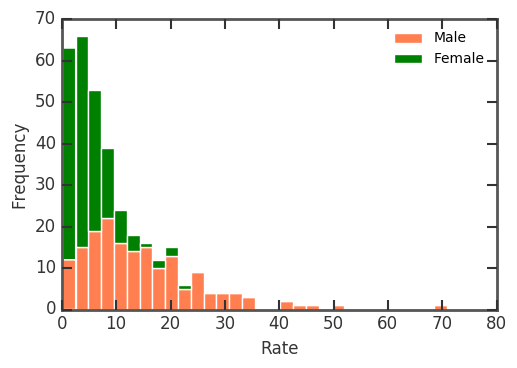

In [65]:
rates.plot.hist(stacked=True,y=['Male', 'Female'],
                bins=30, color=['Coral', 'Green'])
plt.xlabel('Rate');

In [66]:
print(rates['Male'].mean(), rates['Female'].mean())

14.69590643274854 5.0707602339181275


In [67]:
rates.boxplot(['Both', 'Male','Female']);

C:\Users\Magnus\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


In [68]:
print(rates[rates['Both']>40])

   Country  Both  Female  Male
66  Guyana  44.2    22.1  70.8


In [69]:
def plot_cdf(data, plot_range=None, scale_to=None, nbins=False, **kwargs):
    if not nbins:
        nbins= len(data)
    sorted_data = np.array(sorted(data), dtype=np.float64)
    data_range = sorted_data[-1] - sorted_data[0]
    counts, bin_edges = np.histogram(sorted_data, bins=nbins)
    xvalues = bin_edges[1:]
    yvalues = np.cumsum(counts)
    if plot_range is None:
        xmin = xvalues[0]
        xmax = xvalues[-1]
    else:
        xmin, xmax = plot_range
    # pad the arrays
    xvalues = np.concatenate([[xmin, xvalues[0]], xvalues, [xmax]])
    yvalues = np.concatenate([[0.0, 0.0],        yvalues, [yvalues.max()]])
    if scale_to:
        yvalues = yvalues / len(data) * scale_to
    plt.axis([xmin, xmax, 0, yvalues.max()])
    return plt.step(xvalues, yvalues, **kwargs)

In [70]:
plot_cdf(rates['Both'], nbins=50, plot_range=[-5, 70])

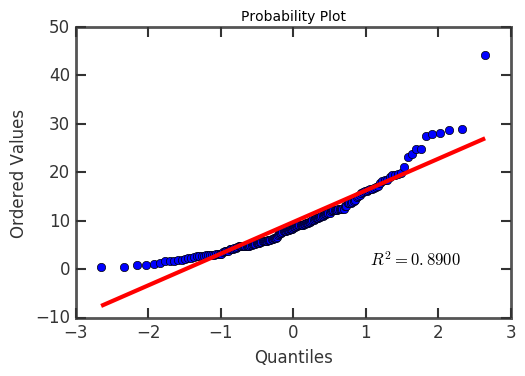

In [71]:
st.probplot(rates['Both'], dist='norm', plot=plt);

In [72]:
eta = 1.
beta = 1.5
rvweib = st.weibull_min(beta, scale=eta)
results = st.probplot(rates['Both'], dist=rvweib, plot=plt)

In [73]:
st.weibull_min.fit?

In [74]:
beta, loc, eta = st.weibull_min.fit(rates['Both'], floc=0, scale = 12)
print(beta, loc, eta)

1.48511424827 0 10.7601476743


In [75]:
rates['Both'].hist(bins=30)
np.random.seed(1100)
rvweib = st.weibull_min(beta, scale=eta)
plt.hist(rvweib.rvs(size=len(rates.Both)),bins=30, alpha=0.5);

In [76]:
plot_cdf(rates['Both'], nbins=50,scale_to=1)
np.random.seed(1100)
plot_cdf(rvweib.rvs(size=50),scale_to=1)
plt.xlim((-2,50));

In [77]:
coords = pandas.read_csv('data/country_centroids/country_centroids_primary.csv', sep='\t')
coords.keys()

Index(['LAT', 'LONG', 'DMS_LAT', 'DMS_LONG', 'MGRS', 'JOG', 'DSG', 'AFFIL',
       'FIPS10', 'SHORT_NAME', 'FULL_NAME', 'MOD_DATE', 'ISO3136'],
      dtype='object')

In [78]:
coords.head()

LAT   LONG  DMS_LAT  DMS_LONG             MGRS      JOG   DSG AFFIL  \
0  33.000000   66.0   330000    660000  42STB1970055286  NI42-09  PCLI   NaN   
1  41.000000   20.0   410000    200000  34TDL1589839239  NK34-08  PCLI   NaN   
2  28.000000    3.0   280000     30000  31REL0000097202  NH31-15  PCLI   NaN   
3 -14.333333 -170.0  -142000  -1700000          1802701      NaN  PCLD    US   
4  42.500000    1.5   423000     13000  31TCH7675006383  NK31-04  PCLI   NaN   

  FIPS10      SHORT_NAME                                FULL_NAME    MOD_DATE  \
0     AF     Afghanistan          Islamic Republic of Afghanistan  2009-04-10   
1     AL         Albania                      Republic of Albania  2007-02-28   
2     AG         Algeria  People's Democratic Republic of Algeria  2011-03-03   
3     AS  American Samoa              Territory of American Samoa  1998-10-06   
4     AN         Andorra                  Principality of Andorra  2007-02-28   

  ISO3136  
0      AF  
1      AL  
2      DZ  
3      AS  
4      AD

In [79]:
rates['Lat'] = ''
rates['Lon'] = ''
for i in coords.index:
    ind = rates.Country.isin([coords.SHORT_NAME[i]])
    val = coords.loc[i, ['LAT', 'LONG']].values.astype('float')
    rates.loc[ind, ['Lat', 'Lon'] ] = list(val)

In [80]:
rates.head()

Country  Both  Female  Male   Lat   Lon
0  Afghanistan   5.7     5.3   6.2    33    66
1      Albania   5.9     5.2   6.6    41    20
2      Algeria   1.9     1.5   2.3    28     3
3       Angola  13.8     7.3  20.7 -12.5  18.5
4    Argentina  10.3     4.1  17.2   -34   -64

In [81]:
rates.loc[rates.Lat.isin(['']), ['Lat']] = np.nan
rates.loc[rates.Lon.isin(['']), ['Lon']] = np.nan
rates[['Lat', 'Lon']] = rates[['Lat', 'Lon']].astype('float')

In [82]:
rates['DFE'] = ''
rates['DFE'] = abs(rates.Lat)
rates['DFE'] = rates['DFE'].astype('float')

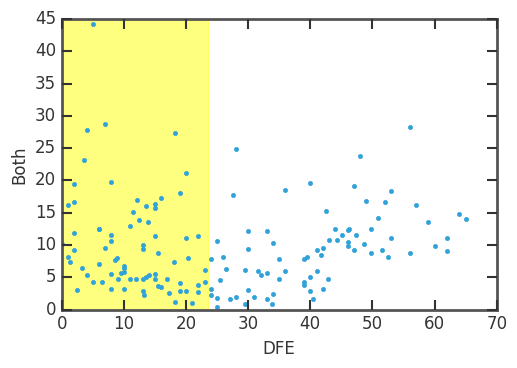

In [83]:
import matplotlib.patches as patches
import matplotlib.transforms as transforms

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(rates.DFE, rates.Both, '.')

trans = transforms.blended_transform_factory(
    ax.transData, ax.transAxes)

rect = patches.Rectangle((0,0), width=23.5, height=1,
                         transform=trans, color='yellow',
                         alpha=0.5)
ax.set_xlabel('DFE')
ax.set_ylabel('Both')
ax.add_patch(rect);

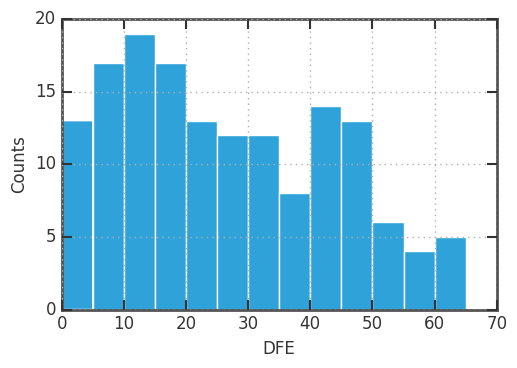

In [84]:
rates.DFE.hist(bins=13)
plt.xlabel('DFE')
plt.ylabel('Counts');

In [85]:
bins = np.arange(23.5, 65+1,10, dtype='float')
bins = np.linspace(23.5, 65,11, dtype='float')
# now group the data into the bins
groups_rates = rates.groupby(np.digitize(rates.DFE, bins))

In [86]:
import matplotlib.patches as patches
import matplotlib.transforms as transforms

fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(groups_rates.mean().DFE, 
            groups_rates.mean().Both, 
            yerr=np.array(groups_rates.std().Both),
            marker='.', 
            ls='None',
            lw=1.5,
            color='Green', 
            ms=1)
ax.plot(rates.DFE, rates.Both, '.', color='SteelBlue', ms=6)
trans = transforms.blended_transform_factory(
    ax.transData, ax.transAxes)

rect = patches.Rectangle((0,0), width=23.5, height=1,
                         transform=trans, color='Yellow',
                         alpha=0.5)
ax.add_patch(rect)
ax.set_xlabel('DFE')
ax.set_ylabel('Both');

# Linear regression

In [87]:
from scipy.stats import linregress
mindfe = 30.
selection = ~rates.DFE.isnull() * rates.DFE>mindfe
rv = rates[selection].as_matrix(columns=['DFE','Both'])
a, b, r, p, stderr = linregress(rv.T)
print('slope:{0:.4f}\nintercept:{1:.4f}\nrvalue:{2:.4f}\npvalue:{3:.4f}\nstderr:{4:.4f}'.format(a, b, r, p, stderr))

slope:0.3204
intercept:-4.2373
rvalue:0.5102
pvalue:0.0000
stderr:0.0715


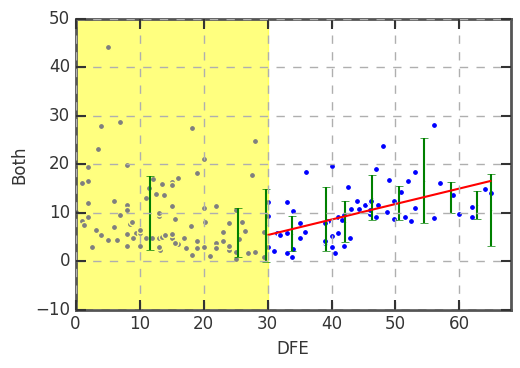

In [88]:
fig = plt.figure()
ax = fig.add_subplot(111)
rates.plot(kind='scatter', x='DFE', y='Both', ax=ax)
xdata = rates['DFE']
xmin, xmax = min(xdata), max(xdata)
xvalues = np.linspace(mindfe, xmax, 200)
yvalues = a * xvalues + b
ax.plot(xvalues, yvalues, color='red', lw=1.5)
ax.grid(lw=1, ls='dashed');


ax.errorbar(groups_rates.mean().DFE, 
            groups_rates.mean().Both, 
            yerr=np.array(groups_rates.std().Both),
            #xerr=,
            marker='.', 
            ls='None',
            lw=1.5,
            color='g', 
            ms=1)

trans = transforms.blended_transform_factory(
    ax.transData, ax.transAxes)

rect = patches.Rectangle((0,0), width=mindfe, height=1,
                         transform=trans, color='yellow',
                         alpha=0.5)

ax.add_patch(rect);
ax.set_xlim((xmin,xmax+3));

In [89]:
import statsmodels.formula.api as smf
mod = smf.ols("Both ~ DFE", rates[selection]).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                   Both   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     20.06
Date:                Sat, 18 Jun 2016   Prob (F-statistic):           3.65e-05
Time:                        20:39:22   Log-Likelihood:                -175.72
No. Observations:                  59   AIC:                             355.4
Df Residuals:                      57   BIC:                             359.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -4.2373      3.272     -1.295      0.2

In [90]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
prstd, iv_l, iv_u = wls_prediction_std(mod)

fig = plt.figure()
ax = fig.add_subplot(111)
rates.plot(kind='scatter', x='DFE', y='Both', ax=ax)

xmin, xmax = min(rates['DFE']), max(rates['DFE'])

ax.plot([mindfe, xmax], [mod.fittedvalues.min(), mod.fittedvalues.max()], 
        'IndianRed', lw=1.5)
ax.plot([mindfe, xmax], [iv_u.min(), iv_u.max()], 'r--', lw=1.5)
ax.plot([mindfe, xmax], [iv_l.min(), iv_l.max()], 'r--', lw=1.5)

ax.errorbar(groups_rates.mean().DFE, 
            groups_rates.mean().Both, 
            yerr=np.array(groups_rates.std().Both),
            ls='None',
            lw=1.5,
            color='Green')

trans = transforms.blended_transform_factory(
    ax.transData, ax.transAxes)

rect = patches.Rectangle((0,0), width=mindfe, height=1,
                         transform=trans, color='Yellow',
                         alpha=0.5)

ax.add_patch(rect)
ax.grid(lw=1, ls='dashed')
ax.set_xlim((xmin,xmax+3));


In [91]:
from pandas.io import data, wb

In [92]:
wb.search('gdp.*capita.*').iloc[:,:2].head(10)

id                                               name
685   6.0.GDPpc_constant  GDP per capita, PPP (constant 2011 internation...
7287      NE.GDI.FTOT.CR  GDP expenditure on gross fixed capital formati...
7337   NV.AGR.PCAP.KD.ZG   Real agricultural GDP per capita growth rate (%)
7458      NY.GDP.PCAP.CD                       GDP per capita (current US$)
7459      NY.GDP.PCAP.CN                       GDP per capita (current LCU)
7460      NY.GDP.PCAP.KD                 GDP per capita (constant 2005 US$)
7461   NY.GDP.PCAP.KD.ZG                   GDP per capita growth (annual %)
7462      NY.GDP.PCAP.KN                      GDP per capita (constant LCU)
7463   NY.GDP.PCAP.PP.CD      GDP per capita, PPP (current international $)
7464   NY.GDP.PCAP.PP.KD  GDP per capita, PPP (constant 2011 internation...

In [93]:
dat = wb.download(indicator='NY.GDP.PCAP.PP.CD', country='all', start=2014, end=2014)
#dat = wb.download(indicator='NY.GDP.PCAP.PP.KD', country='all', start=2014, end=2014)
dat.head()

NY.GDP.PCAP.PP.CD
country                                 year                   
Arab World                              2014       15982.946646
Caribbean small states                  2014       15232.627099
Central Europe and the Baltics          2014       24525.124497
East Asia & Pacific (all income levels) 2014       14861.759632
East Asia & Pacific (developing only)   2014       11922.727321

In [94]:
country = np.array(dat.index.tolist())[:,0]
gdp = np.array(np.array(dat['NY.GDP.PCAP.PP.CD']))
data = pd.DataFrame(data=np.array([country,gdp]).T, columns=['country', 'gdp'])
print(dat['NY.GDP.PCAP.PP.CD'].head())
print(data.head())

country                                  year
Arab World                               2014    15982.946646
Caribbean small states                   2014    15232.627099
Central Europe and the Baltics           2014    24525.124497
East Asia & Pacific (all income levels)  2014    14861.759632
East Asia & Pacific (developing only)    2014    11922.727321
Name: NY.GDP.PCAP.PP.CD, dtype: float64
                                   country                 gdp
0                               Arab World    15982.9466455262
1                   Caribbean small states    15232.6270994351
2           Central Europe and the Baltics    24525.1244974717
3  East Asia & Pacific (all income levels)  14861.759631929799
4    East Asia & Pacific (developing only)    11922.7273213879


In [95]:
rates['GDP_CD'] = ''
for i in np.arange(len(data)):
    rates.loc[rates.Country.isin([data.country[i]]), ['GDP_CD'] ] = data.loc[i, ['gdp']].values.astype('float')
rates.loc[rates.GDP_CD.isin(['']), ['GDP_CD']] = np.nan

In [96]:
print(rates[rates.Country=='Sweden'])
print(data[data.country=='Sweden'])
print(data.loc[218, ['gdp']].values.astype('float'))
rates.loc[rates.Country.isin(['Sweden'])]

    Country  Both  Female  Male  Lat  Lon  DFE GDP_CD
146  Sweden  11.1     6.1  16.2   62   15   62  45297
    country               gdp
218  Sweden  45296.9562604006
[ 45296.9562604]


Country  Both  Female  Male  Lat  Lon  DFE GDP_CD
146  Sweden  11.1     6.1  16.2   62   15   62  45297

In [97]:
selection = ~rates.DFE.isnull() * rates.DFE>mindfe
selection *=  ~rates.GDP_CD.isnull()

C:\Users\Magnus\Anaconda3\lib\site-packages\pandas\computation\expressions.py:190: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


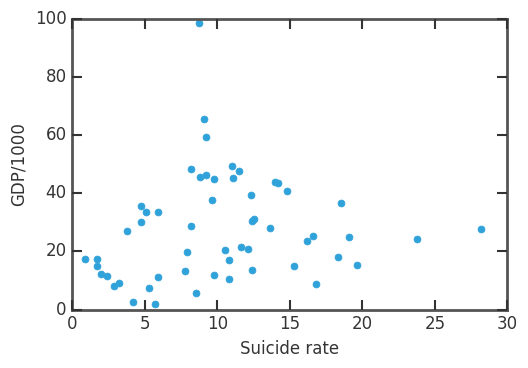

In [98]:
plt.plot(rates[selection].Both.values, rates[selection].GDP_CD.values/1000, '.', ms=10)
plt.ylabel('GDP/1000')
plt.xlabel('Suicide rate');

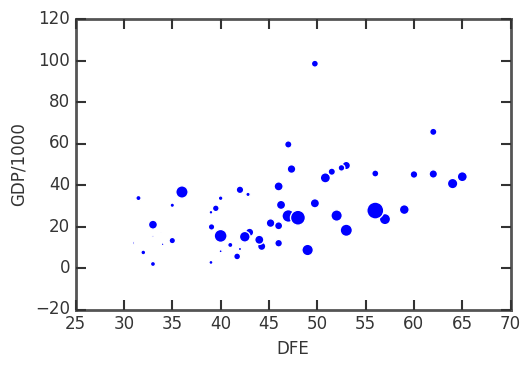

In [99]:
plt.scatter(rates[selection].DFE.values, rates[selection].GDP_CD.values/1000, s=rates[selection].Both.values**1.5)
plt.ylabel('GDP/1000')
plt.xlabel('DFE');

In [100]:
import statsmodels.api as sm

A = rates[selection][['DFE', 'GDP_CD']].astype('float')
A['GDP_CD'] = A['GDP_CD']/1000
b = rates[selection]['Both'].astype('float')
A = sm.add_constant(A)
est = sm.OLS(b, A).fit()

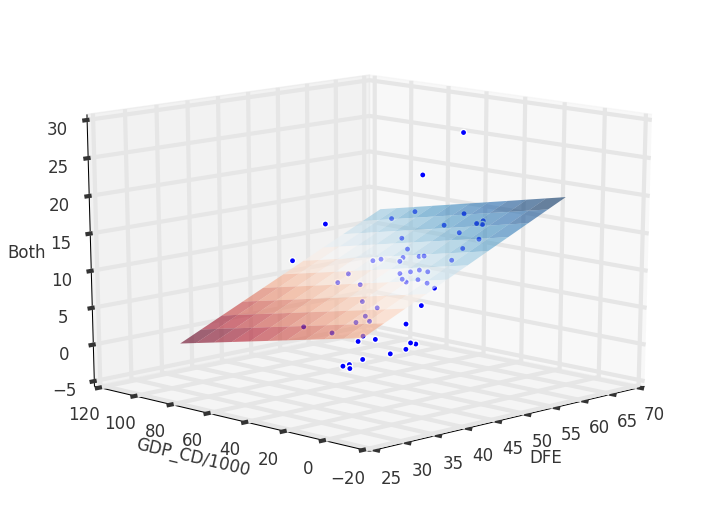

In [101]:
from mpl_toolkits.mplot3d import Axes3D
X, Y = np.meshgrid(np.linspace(A.DFE.min(), A.DFE.max(), 100), 
                       np.linspace(A.GDP_CD.min(), A.GDP_CD.max(), 100))
Z = est.params[0] + est.params[1] * X + est.params[2] * Y


fig = plt.figure(figsize=(7, 5))
ax = Axes3D(fig, azim=-135, elev=15)

surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.RdBu, alpha=0.6, linewidth=0)


resid = b - est.predict(A)
ax.scatter(A.DFE, A.GDP_CD, b,  alpha=1.0)

ax.set_xlabel('DFE')
ax.set_ylabel('GDP_CD/1000')
ax.set_zlabel('Both');

In [102]:
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                   Both   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     10.52
Date:                Sat, 18 Jun 2016   Prob (F-statistic):           0.000146
Time:                        20:39:36   Log-Likelihood:                -164.40
No. Observations:                  55   AIC:                             334.8
Df Residuals:                      52   BIC:                             340.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -5.8722      3.577     -1.641      0.1

In [119]:
# now plot the whole distribution, show that it is not really easy. Intersting to identify clusters
# save datafram for next chapter. 
# also, test 3D plot with %matplotlib notebook
# for interactive plots.
%matplotlib notebook
selection2 = ~rates.DFE.isnull()

plt.scatter(rates[selection2].GDP_CD.values/1000, rates[selection2].DFE.values, s=rates[selection2].Both.values**1.5)
plt.xlabel('GDP/1000')
plt.ylabel('DFE');

<IPython.core.display.Javascript object>

In [44]:
data = pd.DataFrame(data=rates[['Country','Both','Male','Female','GDP_CD', 'DFE']][~rates.DFE.isnull()])
data.head()

Country  Both  Male  Female   GDP_CD   DFE
0  Afghanistan   5.7   6.2     5.3  1932.89  33.0
1      Albania   5.9   6.6     5.2    11108  41.0
2      Algeria   1.9   2.3     1.5  14193.4  28.0
3       Angola  13.8  20.7     7.3      NaN  12.5
4    Argentina  10.3  17.2     4.1      NaN  34.0

In [104]:
TABLE_FILE = 'data_ch4.h5'
data.to_hdf(TABLE_FILE, 'ch4data', mode='w', table=True)

In [105]:
d2 = pd.read_hdf(TABLE_FILE)
d2.head()

country                 gdp
0                               Arab World    15982.9466455262
1                   Caribbean small states    15232.6270994351
2           Central Europe and the Baltics    24525.1244974717
3  East Asia & Pacific (all income levels)  14861.759631929799
4    East Asia & Pacific (developing only)    11922.7273213879

# Logistic regression

In [106]:
k = 1.
m = -5.

y = lambda x: k*x + m
#p = lambda x: np.exp(k*x+m) / (1+np.exp(k*x+m))
p = lambda x: 1 / (1+np.exp(-1*(k*x+m)))

In [107]:
xx = np.linspace(0,10)
plt.plot(xx,y(xx), label='linear')
plt.plot(xx,p(xx), label='logistic')
plt.plot([0,abs(m)], [0.5,0.5], dashes=(4,4), color='.7')
plt.plot([abs(m),abs(m)], [-.1,.5], dashes=(4,4), color='.7')

# limits, legends and labels
plt.ylim((-.1,1.1))
plt.legend(loc=2)
plt.ylabel('P')
plt.xlabel('xx');

In [108]:
studytime = [0,0,1.5,2,2.5,3,3.5,4,4,4,5.5,6,6.5,7,7,8.5,9,9,9,10.5,10.5,12,12,12,12.5,13,14,15,16,18]
passed = [0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1]
data = pd.DataFrame(data=np.array([studytime,passed]).T, columns=['Time', 'Pass'])

In [109]:
data.Time.hist(bins=6)
plt.xlabel('Time')
plt.ylabel('No. students');

In [110]:
plt.plot(data.Time, data.Pass,'o', mew=0, ms=7,)
plt.ylim(-.1,1.1)
plt.xlim(-0.2,16.2)
plt.xlabel('Time studied')
plt.ylabel('Pass? (0=no, 1=yes)');

In [111]:
import statsmodels.api as sm
probfit = sm.Logit(data.Pass, sm.add_constant(data.Time, prepend=True))

In [112]:
fit_results = probfit.fit()

Optimization terminated successfully.
         Current function value: 0.251107
         Iterations 8


In [113]:
print(fit_results.summary())

                           Logit Regression Results                           
Dep. Variable:                   Pass   No. Observations:                   30
Model:                          Logit   Df Residuals:                       28
Method:                           MLE   Df Model:                            1
Date:                Sat, 18 Jun 2016   Pseudo R-squ.:                  0.6366
Time:                        20:39:48   Log-Likelihood:                -7.5332
converged:                       True   LL-Null:                       -20.728
                                        LLR p-value:                 2.791e-07
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -5.7980      2.240     -2.588      0.010       -10.188    -1.408
Time           0.8020      0.297      2.703      0.007         0.220     1.384


In [114]:
logit_pars = fit_results.params
intercept_err, slope_err = np.diag(fit_results.cov_params())**.5
fit_results.cov_params()

const      Time
const  5.017663 -0.635081
Time  -0.635081  0.088035

In [115]:
intercept = logit_pars['const']
slope = logit_pars['Time']
print(intercept,slope)

-5.79798670884 0.801979232718


In [116]:
fit_results.conf_int()

0         1
const -10.188333 -1.407640
Time    0.220444  1.383514

In [117]:
plt.plot(data.Time, data.Pass,'o', mew=0, ms=7, label='Data')
p = lambda x,k,m: 1 / (1+np.exp(-1*(k*x+m)))
xx = np.linspace(0,data.Time.max())
l1 = plt.plot(xx, p(xx,slope,intercept), label='Fit')
plt.fill_between(xx,
    p(xx,slope+slope_err**2, intercept+intercept_err),
    p(xx,slope-slope_err**2, intercept-intercept_err), 
    alpha=0.15,
    color=l1[0].get_color())
plt.ylim(-.1,1.1)
plt.xlim(-0.2,16.2)
plt.xlabel('Time studied')
plt.ylabel('Pass? (0=no, 1=yes)')
plt.legend(loc=2, numpoints=1);

In [118]:
target=0.5
x_prob = lambda p,k,m: (np.log(p/(1-p))-m)/k
T_max = x_prob(target, slope-slope_err, intercept-intercept_err)
T_min = x_prob(target, slope+slope_err, intercept+intercept_err)
T_best = x_prob(target, slope, intercept)
print('{0}% sucess rate: {1:.1f} +{2:.1f}/-{3:.1f}'.format(int(target*100),T_best,T_max-T_best,T_best-T_min))

50% sucess rate: 7.2 +8.7/-4.0
